# Time Series Analysis with SARIMAX

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import model_selection

In [12]:
df = pd.read_csv("nyc_data.csv", index_col=0, parse_dates=True)
df = df.rename(columns={"Demand":"y"})
df.head(1)

,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305


In [13]:
X = df.iloc[:, 1:]
X.head(2)

,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,
2015-01-01,0,0,0,3.68,41.305
2015-01-02,0,0,0,4.73,131.574


### Stationarity

In [15]:
pvalue = adfuller(x=df.y)[1]
if pvalue < 0.05:
    print(f"The Time Series is stationary. The p-value is {pvalue:.4f}")
else:
    print(f"The Time Series is not stationary. The p-value is {pvalue:.4f}")

The Time Series is not stationary. The p-value is 0.3768


In [16]:
pvalue = adfuller(x=df.y.diff().dropna())[1]
if pvalue < 0.05:
    print(f"The Time Series is stationary. The p-value is {pvalue:.4f}")
else:
    print(f"The Time Series is not stationary. The p-value is {pvalue:.4f}")

The Time Series is stationary. The p-value is 0.0000


## SARIMAX Model

In [6]:
#Model
model = pm.ARIMA(order=(1,1,1),
                 seasonal_order=(1,1,1,7),
                 X=X,
                 suppress_warnings=True,
                 forse_stationarity=False,
                 )

In [7]:
cv = model_selection.RollingForecastCV(h=31, step=16, initial=df.shape[0]-180)
cv_score = model_selection.cross_val_score(model, 
                                          y = df.y,
                                          scoring='mean_squared_error',
                                          cv=cv,
                                          verbose=2,
                                          error_score=10000000000000)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


In [8]:
np.sqrt(np.mean(cv_score))

59.95531478362696

### Parameter tuning

In [9]:
param_grid = {'p':[0, 1],
              'd':[0],
              'q':[0,1],
              'P':[0,1],
              'D':[0,1],
              'Q':[0,1]}
grid = ParameterGrid(param_grid)

In [21]:
grid[10]

{'q': 0, 'p': 1, 'd': 0, 'Q': 0, 'P': 1, 'D': 0}

In [23]:
rmse = []
i = 0
for param in grid:
    print(f'Run {i + 1}')
    if (i + 1) == 11:
        i += 1
        continue
    model = pm.ARIMA(order=(param['p'],param['d'],param['q']),
                 seasonal_order=(param['P'],param['D'],param['Q'],7),
                 X=X,
                 suppress_warnings=True,
                 forse_stationarity=False,
                 )
    cv = model_selection.RollingForecastCV(h=31, step=16, initial=df.shape[0]-180)
    cv_score = model_selection.cross_val_score(model, 
                                            y = df.y,
                                            scoring='mean_squared_error',
                                            cv=cv,
                                            verbose=0,
                                            error_score=10000000000000)
    error = np.sqrt(np.mean(cv_score))
    rmse.append(error) 
    
    i += 1

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Run 30
Run 31
Run 32


In [30]:
df = pd.read_csv('nyc_data.csv', index_col=0, parse_dates=True)
df_future = pd.read_csv('future.csv', index_col=0, parse_dates=True)
df = df.rename(columns={'Demand':'y'})
X_train = df.iloc[:,1:]
X_future = df_future.iloc[:,1:]
X_train.head(2), X_future.head(2)

(            Easter  Thanksgiving  Christmas  Temperature  Marketing
 Date                                                               
 2015-01-01       0             0          0         3.68     41.305
 2015-01-02       0             0          0         4.73    131.574,
             Easter  Thanksgiving  Christmas  Temperature  Marketing
 Date                                                               
 2021-01-01       0             0          0         5.00    154.221
 2021-01-02       0             0          0        11.11    264.805)

In [27]:
best_params = grid[np.argmin(rmse)]

In [33]:
model = pm.ARIMA(order=(best_params['p'], best_params['d'], best_params['q']),
                 seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], 7),
                 X = X_train,
                 suppress_warnings=True,
                 force_stationarity=False)
model.fit(df.y)

ARIMA(order=(1, 0, 0), seasonal_order=(0, 1, 1, 7), suppress_warnings=True)

In [34]:
predictions = model.predict(n_periods=len(X_future),
                            X=X_future)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['X', 'force_stationarity']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Date'>

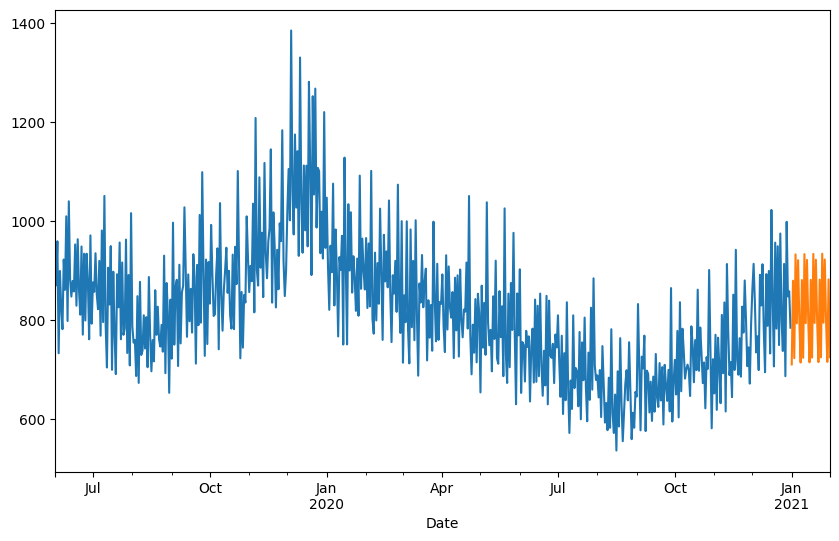

In [41]:
df['y']['2019-6-01':].plot(figsize=(10, 6))
predictions.plot()